In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
# Import the data from the files into DataFrames and make datetime objects real datetime objects 
with open('Data/Dodgers.data','rb') as f:
    traffic = pd.read_csv(f,names=('Datetime','count'),encoding='ISO 8859-1')
    traffic['Datetime'] = pd.to_datetime(traffic.Datetime,format= '%m/%d/%Y %H:%M')
    
with open('Data/Dodgers.events','rb') as f:
    events = pd.read_csv(f,names=('Date','start_event','end_event','Game attendance','Away team','W/L score'),encoding='ISO 8859-1')
    events['start_event'] = pd.to_datetime(events.Date+'_'+events.start_event,format= '%m/%d/%y_%H:%M:%S')
    events['end_event'] = pd.to_datetime(events.Date+'_'+events.end_event,format= '%m/%d/%y_%H:%M:%S')
    events['Date'] = pd.to_datetime(events.Date,format= '%m/%d/%y')
    
with open('Data/CalIt2.data','r') as f:
    calTraffic = pd.read_csv(f,names=('direction','date','time','num'),encoding='iso-8859-1')
    calTraffic['datetime'] = pd.to_datetime(calTraffic.date+'_'+calTraffic.time,format= '%m/%d/%y_%H:%M:%S')
    calTraffic['date'] = pd.to_datetime(calTraffic.date,format= '%m/%d/%y')
    
with open('Data/CalIt2.events','rb') as f:
    calEvent= pd.read_csv(f,names=('Date','start_event','end_event','name'),encoding='ISO 8859-1') 
    calEvent['start_event'] = pd.to_datetime(calEvent.Date+'_'+calEvent.start_event,format= '%m/%d/%y_%H:%M:%S')
    calEvent['end_event'] = pd.to_datetime(calEvent.Date+'_'+calEvent.end_event,format= '%m/%d/%y_%H:%M:%S')
    calEvent['Date'] = pd.to_datetime(calEvent.Date,format= '%m/%d/%y')

events.head()



,Date,start_event,end_event,Game attendance,Away team,W/L score
0,2005-04-12,2005-04-12 13:10:00,2005-04-12 16:23:00,55892,San Francisco,W 9-8
1,2005-04-13,2005-04-13 19:10:00,2005-04-13 21:48:00,46514,San Francisco,W 4-1
2,2005-04-15,2005-04-15 19:40:00,2005-04-15 21:48:00,51816,San Diego,W 4-0
3,2005-04-16,2005-04-16 19:10:00,2005-04-16 21:52:00,54704,San Diego,W 8-3
4,2005-04-17,2005-04-17 13:10:00,2005-04-17 15:31:00,53402,San Diego,W 6-0


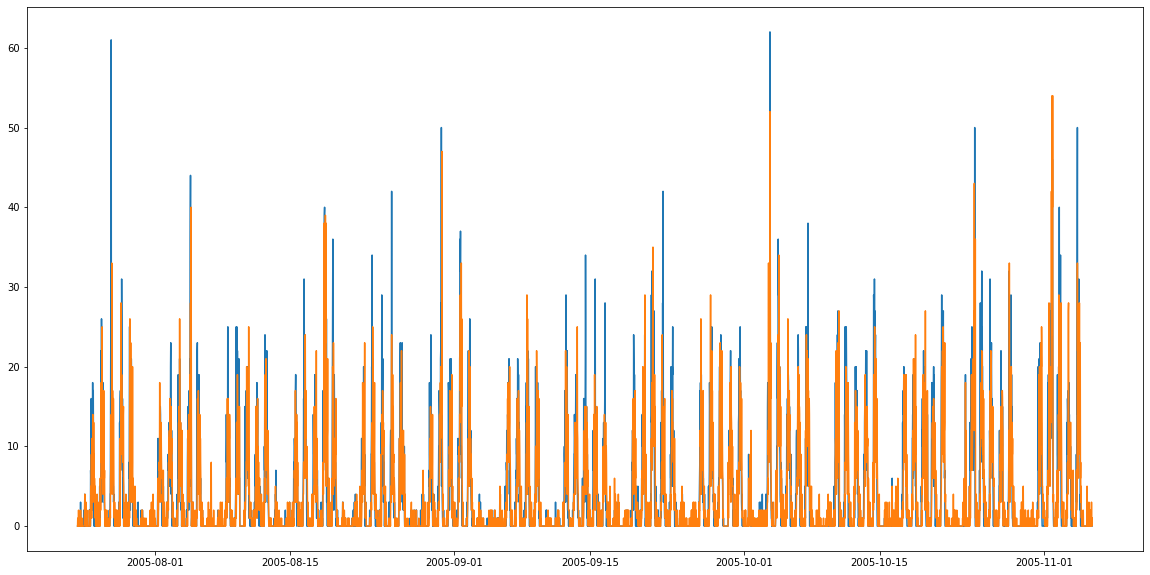

In [3]:
plt.figure(figsize=(20,10))

start = datetime.datetime.strptime("21-06-2014", "%d-%m-%Y")
end = datetime.datetime.strptime("07-07-2014", "%d-%m-%Y")

plt.plot(calTraffic[calTraffic.direction==9].datetime,calTraffic[calTraffic.direction==9].num)
plt.plot(calTraffic[calTraffic.direction==7].datetime,calTraffic[calTraffic.direction==7].num)

plt.show()



In [4]:
#Initiallize columns for events with outcomes and scores of home and away team
events['Outcome'] = 'W'
events['Score 1'] = 0
events['Score 2'] = 0


In [5]:
# Populate the scores with the data from the "W/L score" collumn
for ii in range(len(events)):
    #temp = re.split('  |- ', str(events.at[ii, 'W/L score']))
    temp1 = str(events.at[ii, 'W/L score']).split(' ')
    temp2 = temp1[1].split('-')
    events.at[ii, 'Outcome'] = temp1[0]
    events.at[ii, 'Score 1'] = int(temp2[0])
    events.at[ii, 'Score 2'] = int(temp2[1][:len(temp2[1])-1])


In [6]:
#one hot encode the win loss into 3 categoies (win loss and close game)
events['big_win'] = 0
events['big_loss'] = 0
events['close_game'] = 0

events.loc[list(events[(events['Outcome'] == 'W') & (events['Score 1']-events['Score 2']  > 3)].index), ['big_win']] = 1
events.loc[list(events[(events['Outcome'] == 'L') & (events['Score 1']-events['Score 2']  > 3)].index), ['big_loss']] = 1
events.loc[list(events[events['Score 1']-events['Score 2']  <= 3].index), ['close_game']] = 1
events

,Date,start_event,end_event,Game attendance,Away team,W/L score,Outcome,Score 1,Score 2,big_win,big_loss,close_game
0,2005-04-12,2005-04-12 13:10:00,2005-04-12 16:23:00,55892,San Francisco,W 9-8,W,9,8,0,0,1
1,2005-04-13,2005-04-13 19:10:00,2005-04-13 21:48:00,46514,San Francisco,W 4-1,W,4,1,0,0,1
2,2005-04-15,2005-04-15 19:40:00,2005-04-15 21:48:00,51816,San Diego,W 4-0,W,4,0,1,0,0
3,2005-04-16,2005-04-16 19:10:00,2005-04-16 21:52:00,54704,San Diego,W 8-3,W,8,3,1,0,0
4,2005-04-17,2005-04-17 13:10:00,2005-04-17 15:31:00,53402,San Diego,W 6-0,W,6,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
76,2005-09-25,2005-09-25 13:10:00,2005-09-25 16:06:00,37846,Pittsburgh,W 9-2,W,9,2,1,0,0
77,2005-09-26,2005-09-26 19:10:00,2005-09-26 22:27:00,36397,Pittsburgh,W 9-4,W,9,4,1,0,0
78,2005-09-27,2005-09-27 19:10:00,2005-09-27 21:33:00,42604,Arizona,L 2-0,L,2,0,0,0,1
79,2005-09-28,2005-09-28 19:10:00,2005-09-28 21:58:00,46424,Arizona,L 4-3,L,4,3,0,0,1


In [7]:
# Drop -1 values from the traffic df
neg_indecies = traffic[traffic['count'] == -1].index
traffic =  traffic.drop(neg_indecies ,axis=0)
traffic = traffic.set_index('Datetime')
traffic = traffic.reset_index()


In [8]:
#create cols for the traffic df
traffic['big_win']=0
traffic['big_loss']=0
traffic['close_game']=0
traffic['no_game']=1

#assign each value in the traffic df to one of 4 groups, (Big Win, Big Loss, Close Game, No Game Being Played)
for i,(s,e,w,l,c) in events[['start_event','end_event','big_win','big_loss','close_game']].iterrows():    
    ind=traffic[s<traffic['Datetime']][traffic[s<traffic['Datetime']]['Datetime']<e].index
    traffic.iloc[list(ind[:]),[2,3,4]] = w,l,c
    
traffic['no_game']= traffic['no_game']-traffic['big_win']-traffic['big_loss']-traffic['close_game']


In [9]:
print(traffic['big_win'].sum() )
print(traffic['big_loss'].sum() )
print(traffic['close_game'].sum() )
print(traffic['no_game'].sum() )
print(traffic.shape)


507
506
1607
44877
(47497, 6)


In [21]:
# create a set of training examples, each being the length of one game with the length being constant. 
max_time = (events['end_event']-events['start_event']).max().round('H')
pad_time = datetime.timedelta(hours=1)
traffic.columns
print(max_time.hours)

AttributeError: 'Timedelta' object has no attribute 'hours'

In [24]:
max_time.seconds/3600


4.0

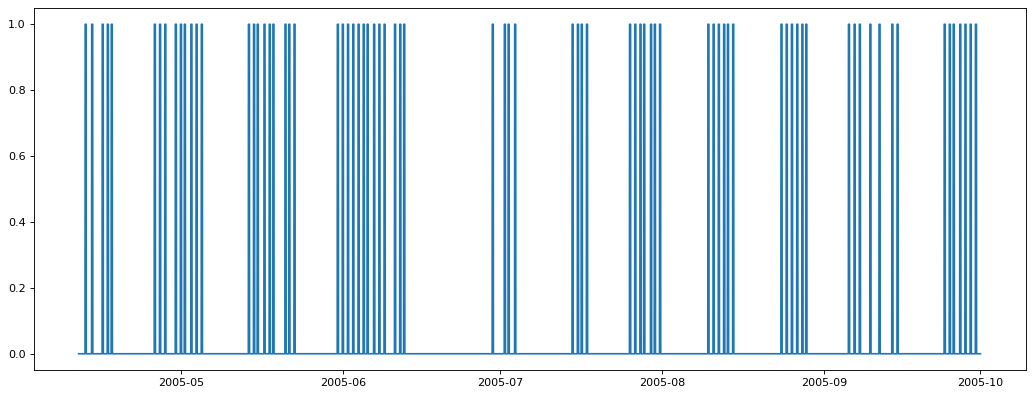

Index(['Datetime', 'count', 'big_win', 'big_loss', 'close_game', 'no_game',
       'game_time'],
      dtype='object')


In [27]:

#create cols to hold boolean for whether you are within 1 hour of a game
traffic['game_time']=0

for i,(s,_) in events[['start_event','end_event']].iterrows():
    #print("s", s)
    s,e = s,s+max_time+pad_time
    #print(s)
    #print("e", e)
    ind=traffic[traffic['Datetime']>=s][traffic[traffic['Datetime']>=s]['Datetime']<=e].index
    #print(traffic[traffic['Datetime']>s & traffic['Datetime']<e])
    #print(len(ind))
    if len(ind) <(max_time.seconds/3600 + 1)*12+1:
        # If there is missing data within the game time throw it out
        #print(len(ind))
        #print(events.values[i][1],events.values[i][1]+max_time+pad_time)
        traffic = traffic.drop(axis=0, index=ind)
        #continue
    
    traffic.iloc[list(ind[:]),[6]] = 1

plt.figure(figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(traffic['Datetime'],traffic['game_time'])
plt.show()
print(traffic.columns)


In [29]:
import tqdm

In [30]:

# Create 6 hour blocks to view traffic right before and right after the game
gt = traffic[['game_time']].values
flips= gt[1:]-gt[:-1]
ind = np.reshape(np.nonzero(flips)[0],[-1,2])

# Fill the dataframe with nans where there is a game to train the model
regular_traffic = traffic.copy()
for i,j in ind:
    regular_traffic.loc[i+1:j+1, 'count'] = np.nan

s=traffic['Datetime'].min()
e=traffic['Datetime'].max()
total_samples=(e-s).total_seconds()/300+1
time_steps = [s+datetime.timedelta(minutes=int(5*x)) for x in range(int(total_samples))]
rt = pd.DataFrame(time_steps,columns=['Datetime'])

col = list(regular_traffic.columns)
col.remove('Datetime')

#make all the other non datetime cols and fill with nan
rt[col] = pd.DataFrame([[np.nan for x in range(len(col))]], index=rt.index)

rt = rt.set_index('Datetime')



for ii in tqdm.tqdm_notebook(range(len(regular_traffic))):
#for ii in tqdm.tqdm_notebook(range(1000)):
    rt.loc[regular_traffic.iat[ii, 0], :] = regular_traffic.iloc[ii]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [31]:
rt = rt.reset_index()
rt

,Datetime,count,big_win,big_loss,close_game,no_game,game_time
0,2005-04-11 07:35:00,23.0,0.0,0.0,0.0,1.0,0.0
1,2005-04-11 07:40:00,42.0,0.0,0.0,0.0,1.0,0.0
2,2005-04-11 07:45:00,37.0,0.0,0.0,0.0,1.0,0.0
3,2005-04-11 07:50:00,24.0,0.0,0.0,0.0,1.0,0.0
4,2005-04-11 07:55:00,39.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...
49730,2005-09-30 23:45:00,14.0,0.0,0.0,0.0,1.0,0.0
49731,2005-09-30 23:50:00,12.0,0.0,0.0,0.0,1.0,0.0
49732,2005-09-30 23:55:00,8.0,0.0,0.0,0.0,1.0,0.0
49733,2005-10-01 00:00:00,13.0,0.0,0.0,0.0,1.0,0.0


In [32]:
rt.to_csv('Cleaned_data')

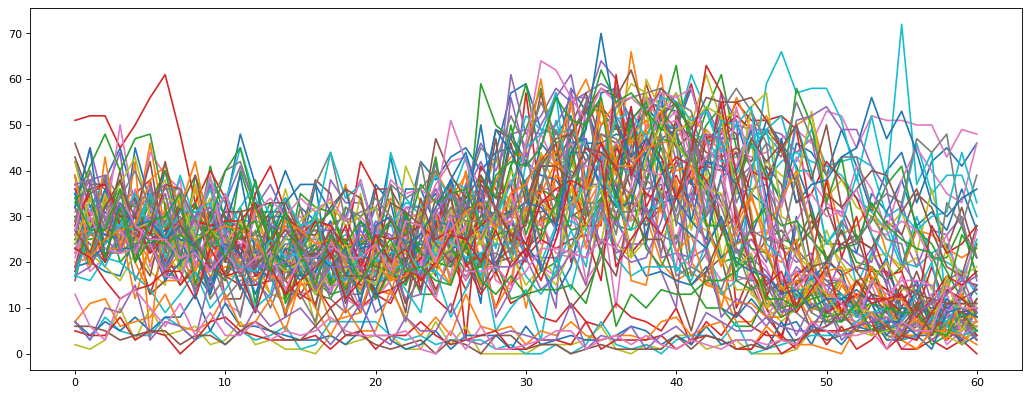

(77, 61, 7)


In [35]:
# create list to hold the 77 games 
data = []

#plot the 77 games on top of one graph
plt.figure(figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
for i in range(ind.shape[0]):
    #traffic['Datetime'].values[ind[i][0]:ind[i][1]]
    data.append(traffic[:].values[ind[i][0]:ind[i][1]])
    plt.plot( np.arange(0,len(traffic['count'].values[ind[i][0]:ind[i][1]])) , traffic['count'].values[ind[i][0]:ind[i][1]])
plt.show()

data = np.array(data)
print(data.shape)



In [36]:
traffic['count'].values[ind[i][0]:ind[i][1]]

array([13,  6,  3, 12, 14, 10,  6, 11,  4,  9,  4,  4,  7,  3,  5,  4,  5,
        8,  5,  4,  4,  4,  5,  1,  0,  5,  1,  6,  1,  1,  2,  3,  5,  5,
        1,  3,  4,  2,  4,  2,  1,  3,  2,  1,  3,  3,  2,  3,  2,  7,  5,
        4,  4,  5,  1,  7,  5,  5, 15, 10, 10])

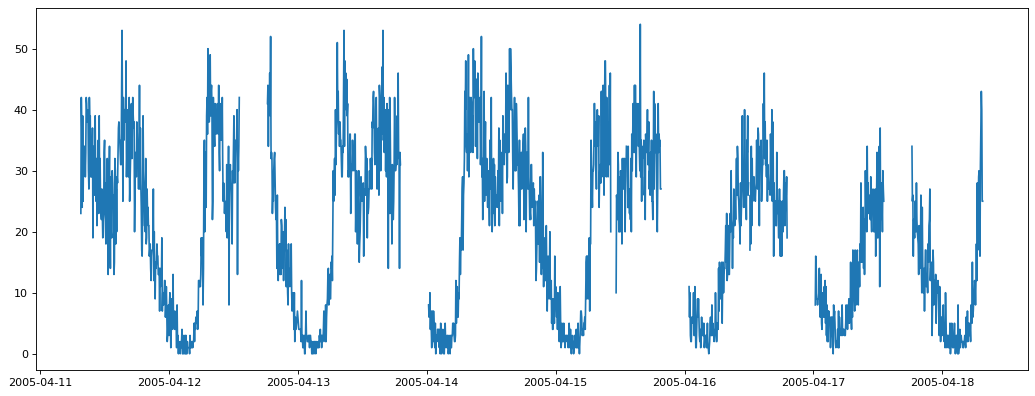

In [37]:
plt.figure(figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(rt['Datetime'][:2016], rt['count'][:2016])

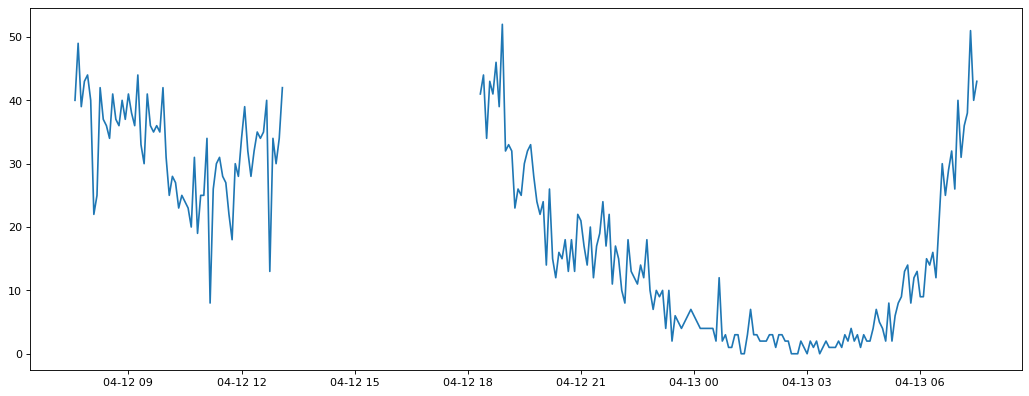

In [38]:
plt.figure(figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(rt['Datetime'][288:288*2], rt['count'][288:288*2])

In [39]:
from statsmodels.tsa.statespace.structural import UnobservedComponents

In [40]:
model = UnobservedComponents(rt['count'], 
                                    level='local level', 
                                    freq_seasonal=[{'period': 331.56666667,
                                                    'harmonics': 1},
                                                   {'period': 292.55882353,
                                                    'harmonics': 1},
                                                  {'period': 290.84795322,
                                                    'harmonics': 1},
                                                   {'period':  274.77900552,
                                                    'harmonics': 1},
                                                  {'period': 143.74277457,
                                                    'harmonics': 1}])


In [41]:
output_res=model.fit(method='powell', disp=True)

Optimization terminated successfully.
         Current function value: 2.692621
         Iterations: 6
         Function evaluations: 558


In [42]:
output_res.summary()

Dep. Variable:,count,No. Observations:,49735
Model:,local level,Log Likelihood,-133917.511
,+ stochastic freq_seasonal(331.56666667(1)),AIC,267849.022
,+ stochastic freq_seasonal(292.55882353(1)),BIC,267910.721
,+ stochastic freq_seasonal(290.84795322(1)),HQIC,267868.354
,+ stochastic freq_seasonal(274.77900552(1)),,
,+ stochastic freq_seasonal(143.74277457(1)),,
Date:,"Mon, 16 Dec 2019",,
Time:,16:10:16,,
Sample:,0,,
,- 49735,,


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/structural.py:1620: MatplotlibDeprecationWarning: Unrecognized location 'lower_right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  ax.legend(handles, labels, loc=legend_loc)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/structural.py:1671: MatplotlibDeprecationWarning: Unrecognized location 'lower_right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  ax.legend(loc=legend_loc)


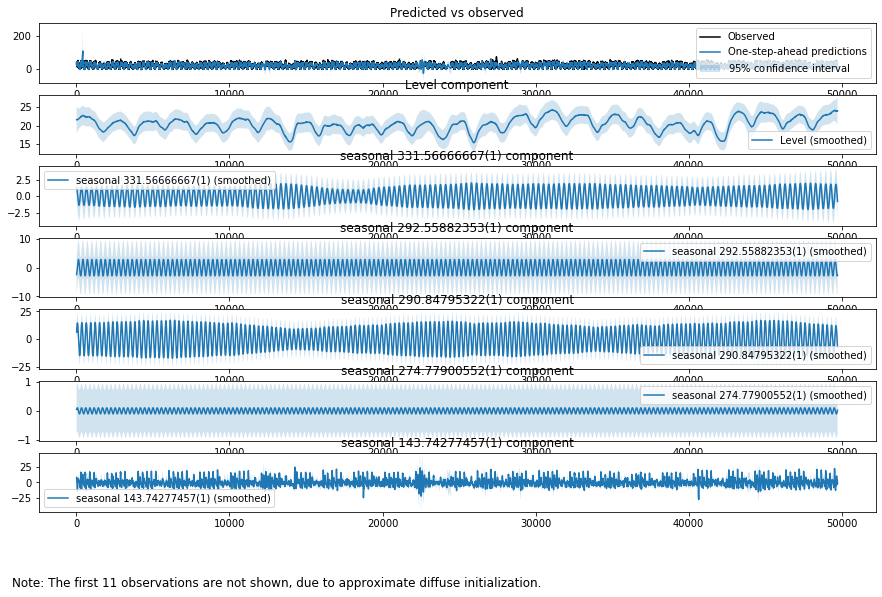

In [43]:
fig = output_res.plot_components(legend_loc='lower_right', figsize=(15,9))

In [44]:
simulate = output_res.get_prediction(0,len(rt)-1)

In [45]:
mean = simulate.predicted_mean

In [46]:
variance = simulate.var_pred_mean

In [47]:
variance.shape

(49735,)

In [119]:
def event_prob(data, prediction_mean, prediction_var):
    return (data-prediction_mean)**2/prediction_var

In [120]:
def difference(data, prediction_mean, prediction_var):
    return (data-prediction_mean)**2

In [121]:
from scipy.signal import butter, lfilter, freqz

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Filter requirements.
order = 6
fs = 1       # sample rate, Hz
cutoff = 1/6  # desired cutoff frequency of the filter, Hz

In [148]:
event_probs = []
differences = []

for i in data[1:67]:
        event_probs.append(event_prob(butter_lowpass_filter(i[:,1].astype(np.float), cutoff, fs, order), mean[rt['Datetime'].isin(i[:,0].tolist())].values, variance[rt['Datetime'].isin(i[:,0].tolist())]))
        event_probs[len(event_probs)-1] = event_probs[len(event_probs)-1][30:]
        event_probs[len(event_probs)-1] = event_probs[len(event_probs)-1]/np.sum(event_probs[len(event_probs)-1])
        
        differences.append(difference(butter_lowpass_filter(i[:,1].astype(np.float), cutoff, fs, order), mean[rt['Datetime'].isin(i[:,0].tolist())].values, variance[rt['Datetime'].isin(i[:,0].tolist())]))
        differences[len(event_probs)-1] = differences[len(event_probs)-1][30:]
        differences[len(event_probs)-1] = differences[len(event_probs)-1]/np.sum(differences[len(event_probs)-1])
        
        

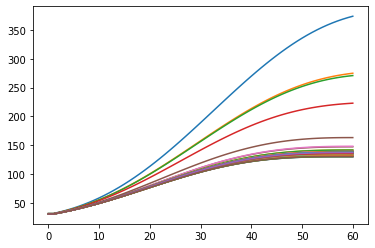

In [149]:
for i in data[1:67]:
    plt.plot(variance[rt['Datetime'].isin(i[:,0].tolist())])
plt.show()

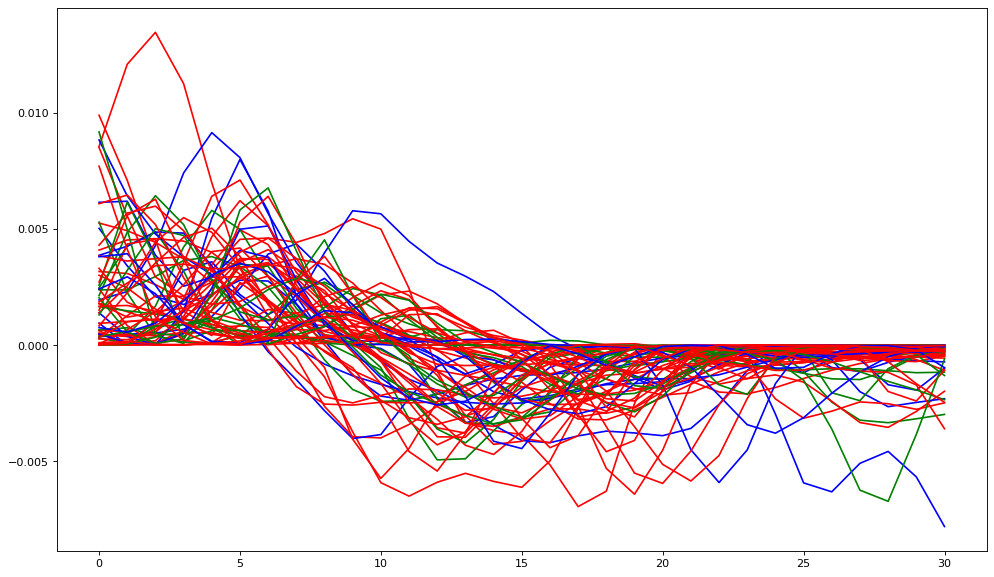

In [150]:
plt.figure(figsize=(15, 9), dpi=80, facecolor='w', edgecolor='k')
for i in range(len(event_probs)):
    if np.any(data[i][:,2] == 1):
        plt.plot(event_probs[i]-differences[i], color='blue')
    elif np.any(data[i][:,3] == 1):
        plt.plot(event_probs[i]-differences[i], color='green')
    elif np.any(data[i][:,4] == 1):
        plt.plot(event_probs[i]-differences[i],color='red')
    else:
        pass
       

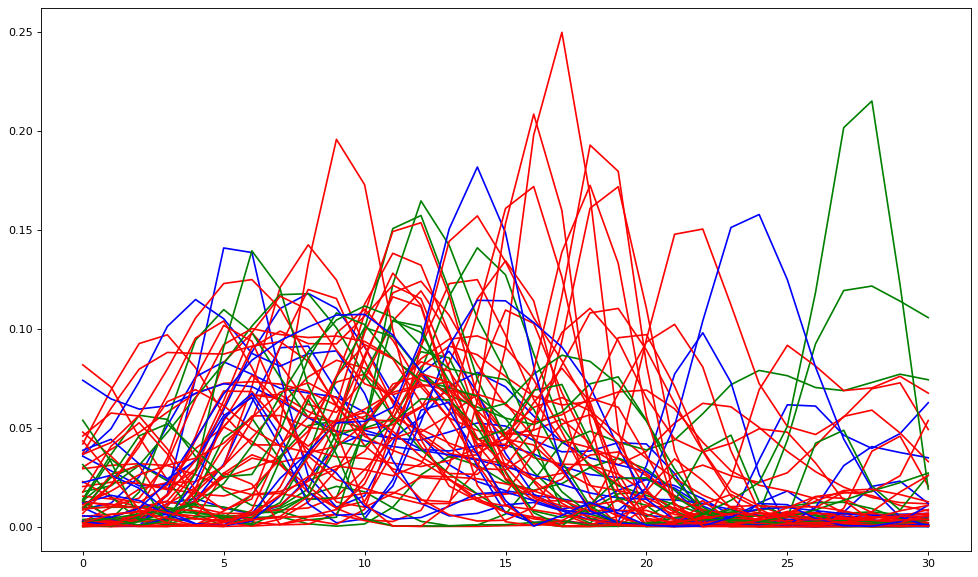

In [151]:
plt.figure(figsize=(15, 9), dpi=80, facecolor='w', edgecolor='k')
for i in range(len(event_probs)):
    if np.any(data[i][:,2] == 1):
        plt.plot(event_probs[i], color='blue')
    elif np.any(data[i][:,3] == 1):
        plt.plot(event_probs[i], color='green')
    elif np.any(data[i][:,4] == 1):
        plt.plot(event_probs[i],color='red')
    else:
        pass
       

In [153]:
event_mean = []
event_var = []

for i in range(len(event_probs)):    
    event_mean.append(np.sum(event_probs[i]*np.arange(len(event_probs[i])))/np.sum(event_probs[i]))
    event_var.append(np.sqrt(np.sum(event_probs[i]*(np.arange(len(event_probs[i]))-event_mean[i])**2)/np.sum(event_probs[i])))

In [154]:
#event_mean = []
#for i in range(len(event_probs)):
    #event_mean.append(np.sum(event_probs[i]*np.arange(72))/np.sum(event_probs[i]))

In [155]:
event_probs[i]

array([1.81366754e-03, 6.02476828e-03, 7.42657394e-03, 4.11034369e-03,
       4.10428730e-04, 7.08323391e-04, 3.31958545e-03, 4.60793225e-03,
       5.12565104e-03, 8.56211696e-03, 2.15190899e-02, 4.97047438e-02,
       7.72619166e-02, 7.28881369e-02, 4.47966303e-02, 3.04428363e-02,
       4.95268635e-02, 1.16569335e-01, 1.92822840e-01, 1.79574195e-01,
       8.19568326e-02, 1.18600957e-02, 6.33312540e-05, 7.90727566e-04,
       5.32384764e-05, 1.47594509e-03, 1.99791499e-03, 2.08772209e-03,
       3.86799176e-03, 7.94096850e-03, 1.06892530e-02])

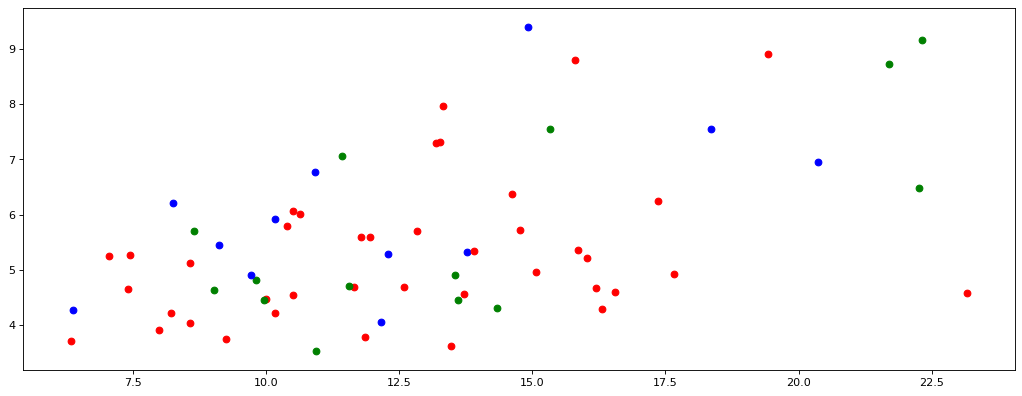

In [156]:
plt.figure(figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')

big_win_mean = 0 
big_win_var = 0

big_win_mean = 0
big_win_var = 0

big_win_mean = 0
big_win_var = 0

for i in range(len(event_probs)):
    if np.any(data[i][:,2] == 1):
        plt.scatter(event_mean[i], event_var[i], color='blue') #big win
        
    elif np.any(data[i][:,3] == 1):
        plt.scatter(event_mean[i], event_var[i], color='green') #big loss
    else:
        plt.scatter(event_mean[i], event_var[i], color='red') #close game
        pass

In [ ]:
for i in range(len(event_probs)):
    for 